### Task Definition: 
Create a Jupyter notebook with a simple analysis based on Twitter Sentiment Analysis Training Corpus:
http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/

— Show the top-10 most positive words, top-10 negative words (words more frequent with positive and negative labels respectively). 

— Check the Zipf law (https://en.wikipedia.org/wiki/Zipf%27s_law: the frequency of any word is inversely proportional to its rank in the frequency table), show it using a plot. 

— Write a simple classifier to predict sentiment, describe your approach and what can be done to improve the results.

In [19]:
import pandas as pd
from nltk.corpus import stopwords

from collections import Counter
import re
#import spacy
#nlp = spacy.load('en')
import numpy as np
from sklearn.metrics import  classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD


In [20]:
stopwords = list(set(stopwords.words('english')))

### Load the dataset

In [21]:
data = pd.read_csv("sent.csv", names=['ufeffItemID','sentiment','SentimentSource','text'])[["sentiment", "text"]].iloc[1:]

/Users/bouyida/anaconda3/envs/analytics/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
data["sentiment"].unique()

array(['0', '1', 0, 1], dtype=object)

In [23]:
data["sentiment"]= data["sentiment"].apply(np.float64) #preprocess target values

In [24]:
data["sentiment"].unique()

array([0., 1.])

This preprocessing routine was taken from [this guthub repo](https://github.com/abdulfatir/twitter-sentiment-analysis/blob/master/preprocess.py)

In [25]:
def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' positive emoji ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positive emoji ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' positive ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' positive emoji ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' negative emoji ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' negative emoji', tweet)
    return tweet

In [26]:
def preprocess(tweet):
    
    #replace emojis 
    tweet = handle_emojis(tweet)  
    #remove punctuation 
    tweet = re.sub(r'[^\w\s]','', tweet)
    #lowercase
    tweet = tweet.lower()
    # Replaces URLs with the word URL
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' link ', tweet)
    # Replace @handle with the word USER_MENTION
    tweet = re.sub(r'@[\S]+', 'user mentioned', tweet)
    # Replaces #hashtag with hashtag
    tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
 #   tweet = " ".join( tok.string for tok in nlp(tweet) )

    return tweet




In [27]:
data["text"] = data["text"].apply(preprocess)

### — Show the top-10 most positive words, top-10 negative words (words more frequent with positive and negative labels respectively). 



In [28]:
neg_words = []
pos_words =[]
for i, sent in data["text"].iteritems():
        if data["sentiment"][i]== 0:
            neg_words.extend(sent.split())
        else:
            pos_words.extend(sent.split())

### Popular neg/positive words without ommitting stop words

In [29]:
Counter(neg_words).most_common(10)

[('i', 458851),
 ('to', 310687),
 ('the', 255648),
 ('my', 187064),
 ('a', 179539),
 ('and', 150890),
 ('is', 126735),
 ('it', 118674),
 ('in', 113935),
 ('im', 102074)]

In [30]:
Counter(pos_words).most_common(10)

[('i', 287124),
 ('the', 262309),
 ('to', 249658),
 ('a', 195585),
 ('you', 174730),
 ('and', 146603),
 ('my', 124092),
 ('for', 116218),
 ('it', 111382),
 ('is', 107606)]

### Let's check the most popular non stop words

In [31]:
neg_words = [w for w in neg_words if w not in stopwords]
pos_words = [w for w in pos_words if w not in stopwords]

In [32]:
Counter(neg_words).most_common(10)

[('im', 102074),
 ('get', 45210),
 ('go', 44660),
 ('dont', 44457),
 ('cant', 43199),
 ('work', 42669),
 ('like', 40475),
 ('day', 37638),
 ('today', 35935),
 ('going', 33171)]

In [33]:
Counter(pos_words).most_common(10)

[('im', 74423),
 ('good', 59525),
 ('love', 46727),
 ('day', 43498),
 ('like', 37039),
 ('get', 35847),
 ('thanks', 33634),
 ('lol', 33344),
 ('going', 30258),
 ('u', 29941)]

### Zipf Law graph

Text(0.5,1,"Zipf's law: frequency versus rank of the first 1000 words")

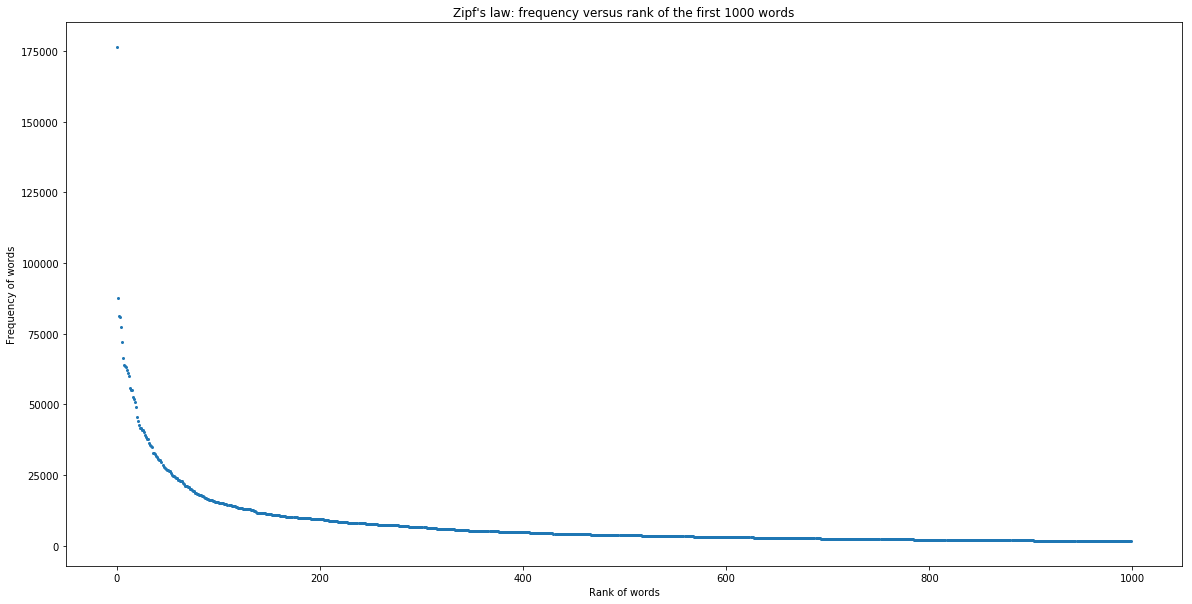

In [49]:
all_words = neg_words+pos_words

count_all = Counter(all_words)

words = list(count_all.keys())
freq = list(count_all.values())

list(count_all.keys())[0]

freq_words = pd.DataFrame({"words": words, "freq": freq})
freq_words = freq_words.sort_values(by=["freq"], ascending=False)
freq_words["rank"] = np.arange(len(freq_words))

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.scatter(x="rank", y="freq", data=freq_words.iloc[:1000], s =4)
plt.xlabel("Rank of words")
plt.ylabel("Frequency of words")
plt.title("Zipf's law: frequency versus rank of the first 1000 words")

### Build sentiment classifier

In [35]:
data = data.sample(frac = 1.0)

### Prepare train,validation,test sets

In [36]:
train_text = data[data["sentiment"]== 1]["text"].iloc[:lentrain].values
y_train = np.ones(lentrain)
train_text = np.append(train_text, data[data["sentiment"]== 0]["text"].iloc[:lentrain])
y_train = np.append(y_train, np.zeros(lentrain))

In [37]:
train_text.shape

(8000,)

In [38]:
lentrain = 8000
lenvalid = 2000
lentest = lenvalid

In [39]:
valid_text = data[data["sentiment"]== 1]["text"].iloc[lentrain:lentrain+lenvalid].values
y_valid = np.ones(lenvalid)
valid_text = np.append(valid_text, data[data["sentiment"]== 0]["text"].iloc[lentrain:lentrain+lenvalid].values)
y_valid = np.append(y_valid, np.zeros(lenvalid))

In [40]:
test_text = data[data["sentiment"]== 1]["text"].iloc[lentrain+lenvalid:lentrain+lenvalid+lentest].values
y_test = np.ones(lentest)
test_text = np.append(test_text, data[data["sentiment"]== 0]["text"].iloc[lentrain+lenvalid:lentrain+lenvalid+lentest])
y_test = np.append(y_test, np.zeros(lentest))d

In [41]:
train = np.column_stack((train_text, y_train)).reshape(-1,2)
valid = np.column_stack((valid_text,y_valid)).reshape(-1,2)
test =np.column_stack((test_text, y_test)).reshape(-1,2)

In [42]:
np.random.shuffle(train)
np.random.shuffle(valid)
np.random.shuffle(test)

### Build TF-IDF vectors

In [43]:
tfidf = TfidfVectorizer(ngram_range=(1,2), analyzer='word')
x_train_tfidf = tfidf.fit_transform(train[:,0])
x_valid_tfidf = tfidf.transform(valid[:,0])
x_test_tfidf = tfidf.transform(test[:,0])

/Users/bouyida/anaconda3/envs/analytics/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


### Reduce dimensionality

In [44]:
svd = TruncatedSVD(n_components = 5000, algorithm = "arpack" )
train_svd = svd.fit_transform(x_train_tfidf)
valid_svd = svd.transform(x_valid_tfidf)
test_svd = svd.transform(x_test_tfidf)

### check how much variance is preserved

In [45]:
svd.explained_variance_ratio_.sum()

0.7849088033880783

### build simple logistic regression model

In [46]:
clf =LogisticRegression()
clf.fit(train_svd, train[:,1].astype('int'))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [47]:
predictions = clf.predict(valid_svd)

print(classification_report(valid[:,1].astype('int'), predictions))



             precision    recall  f1-score   support

          0       0.73      0.79      0.76      2000
          1       0.77      0.70      0.73      2000

avg / total       0.75      0.74      0.74      4000



In [48]:
print(classification_report(test[:,1].astype('int'), clf.predict(test_svd)))



             precision    recall  f1-score   support

          0       0.73      0.78      0.76      2000
          1       0.77      0.72      0.74      2000

avg / total       0.75      0.75      0.75      4000



###  Write a simple classifier to predict sentiment, describe your approach and what can be done to improve the results.

Our dataset includes 1578614 tweets. It is large and classical NLP will be too slow to solve this binary classification problem. 
The simplest solution would be to reduce the size of our dataset by taking into account class imbalance and performing LSA (transform the vectors using TFIDF, reduce dimensionality then perform a simple logistic regression classifier) 

The more sophisticated approach would be to preprocess the data by  tokenizing, lemmatizing the text. Create an embedding matrix using glove or fastext then run an LSTM or a simple RNN as a model.